# Appendix: CCPP Outlier Removal, Data Analysis and Regression Models

Group 2: Verduzco, Darin; Perumal, Manikandan; Romero Olvera, Israel
 
GitHub: https://github.com/isralennon/MSAAI500

Installs:

In [1]:
# pip install mplcyberpunk

# Import Libraries

In [2]:
### Libraries for Machine Learning
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import mplcyberpunk

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from statsmodels.stats import anova
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# Initial Data Descriptions

In [3]:
df = pd.read_csv('CombinedCyclePowerPlant.csv', sep=',')
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


In [5]:
# Check for null values
null_values = df.isnull().sum()

# Check for duplicates
duplicates = df.duplicated().sum()

print(f'\033[4mNull values:\033[0m\n{null_values}\n')
print(f'\033[4mDuplicates:\033[0m\n{duplicates}')

Null values:
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

Duplicates:
41


# Regression plots for all feature variables

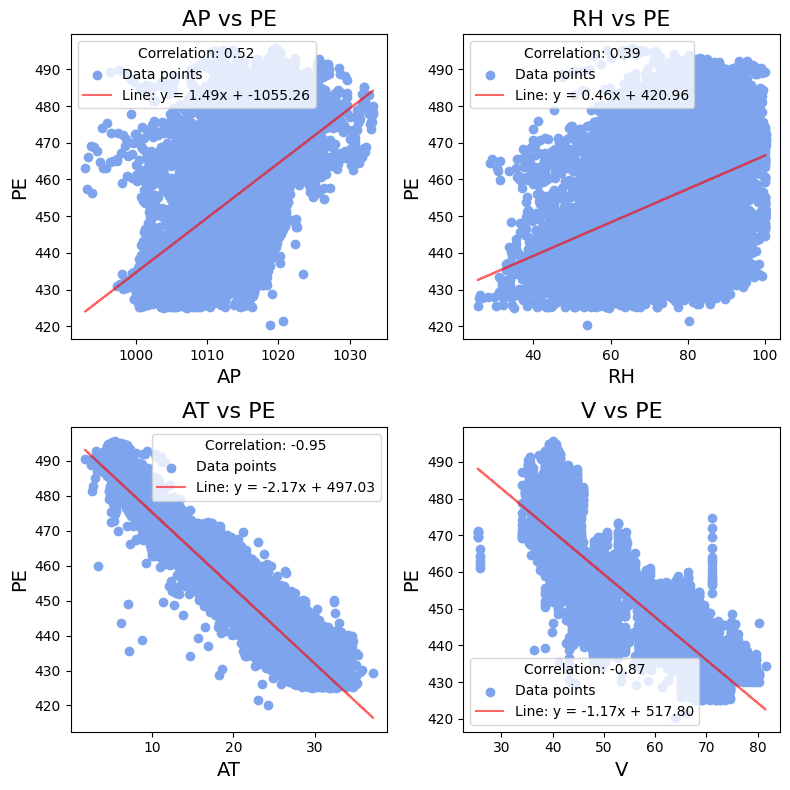

In [6]:
# Define the independent variables
independent_vars = ['AP', 'RH', 'AT', 'V']
y_name = 'PE'

# Create a figure for all plots
plt.figure(figsize=(8, 8)) # (height, width)

# Loop through independent variables and create plots
for i, x_name in enumerate(independent_vars):
    plt.subplot(2, 2, i + 1)  # 2x2 grid of plots
    x = df[x_name]
    y = df[y_name]
    
    plt.scatter(x, y, color='#7da4ec', label='Data points')
    
    # Fit a linear regression line (y = mx + b)
    m, b = np.polyfit(x, y, 1)
    
    # Plot the regression line
    plt.plot(x, m*x + b, color='red', alpha=0.6, label=f'Line: y = {m:.2f}x + {b:.2f}')
    
    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Add the correlation value to the legend
    plt.legend(title=f'Correlation: {correlation:.2f}')
    
    # Add labels and title
    plt.xlabel(x_name, size=14)
    plt.ylabel(y_name, size=14)
    plt.title(f'{x_name} vs {y_name}', size=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Box Plot of Electrical Power Output (PE)

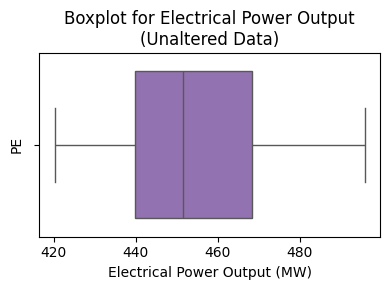

In [7]:
# Normal PE boxplot, renamed columns for readablility
df.columns=[
    'Ambient_Temperature',
    'Vacuum',
    'Atmospheric_Pressure',
    'Relative_Humidity',
    'Electrical_Power_Output'
]
plt.figure(figsize=(4, 3))
sns.boxplot(x=df['Electrical_Power_Output'], color='#9467bd',orient='h') 
plt.title(f'Boxplot for Electrical Power Output\n(Unaltered Data)')
plt.ylabel('PE')
plt.xlabel('Electrical Power Output (MW)')
plt.tight_layout()
plt.show()

# Box plots of PE binned by AT

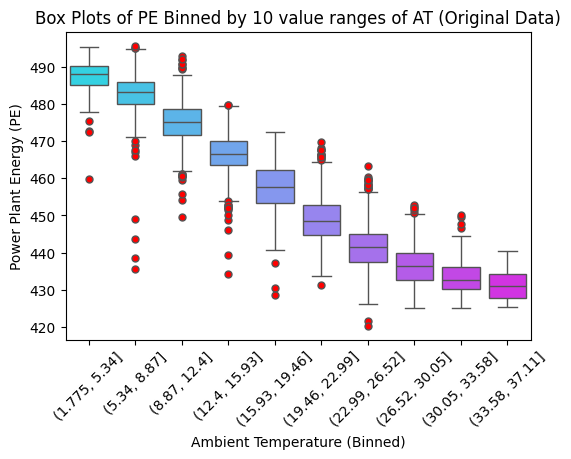

In [8]:
# Create a copy of the original df to avoid altering it
binned_df = df.copy()
# Make a column with 10 bins of Ambient Temperature values
binned_df['Ambient_Temperature_bin'] = pd.cut(binned_df['Ambient_Temperature'], bins=10)

# Red outliers
flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')

# Plot PE vs binned AT, with red outliers
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='Ambient_Temperature_bin',
    y='Electrical_Power_Output',
    data=binned_df, 
    palette='cool',
    hue='Ambient_Temperature_bin',
    legend=False,
    flierprops=flierprops
)
plt.title('Box Plots of PE Binned by 10 value ranges of AT (Original Data)')
plt.xlabel('Ambient Temperature (Binned)')
plt.ylabel('Power Plant Energy (PE)')
plt.xticks(rotation=45, size=10)

# Show the plot
plt.show()

In [9]:
# Function to remove outliers from target var, based on feature
def remove_outliers(df, feature, target):
    # Define Q1,Q3,IQR
    Q1 = df.groupby(feature, observed=False)[target].quantile(0.25)
    Q3 = df.groupby(feature, observed=False)[target].quantile(0.75)
    IQR = Q3 - Q1
    # Define lower and upper limit for removal, adjust scale factor integer as needed
    # Using a scale factor (like IQR) allows for adjustment based on the dataset's characteristics,
    # making the outlier detection process more flexible and context-sensitive
    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR
    # Merge bounds to original dataframe
    bounds_df = pd.DataFrame({'lower_bound': lower_bound, 'upper_bound': upper_bound})
    df = df.merge(bounds_df, how='left', left_on=feature, right_index=True)
    # Outlier index tracking
    outlier_indices = df[(df[target] < df['lower_bound']) | (df[target] > df['upper_bound'])].index
    # Make dataframe without outliers, keep less than upper and above lower bounds
    df_filtered = df[(df[target] >= df['lower_bound']) & (df[target] <= df['upper_bound'])]
    # Drop the columns with bounds
    df_filtered = df_filtered.drop(['lower_bound', 'upper_bound'], axis=1)

    return df_filtered, outlier_indices

# Outlier remove function (1.0 scale factor)

In [10]:
# Function to remove outliers from target var, based on feature, with scale factor
def remove_outliers(df, feature, target, scale_factor=1.0):
    # Define Q1, Q3, IQR
    # Q1: The 25th percentile of the target for each group defined by feature
    Q1 = df.groupby(feature, observed=False)[target].quantile(0.25)
    # Q3: The 75th percentile of the target for each group defined by feature
    Q3 = df.groupby(feature, observed=False)[target].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper limit for removal, using the scale factor
    lower_bound = Q1 - scale_factor * IQR
    upper_bound = Q3 + scale_factor * IQR
    
    # Merge bounds to original dataframe
    bounds_df = pd.DataFrame({'lower_bound': lower_bound, 'upper_bound': upper_bound})
    df = df.merge(bounds_df, how='left', left_on=feature, right_index=True)
    
    # Outlier index tracking
    outlier_indices = df[(df[target] < df['lower_bound']) | (df[target] > df['upper_bound'])].index
    
    # Make dataframe without outliers, 
    # Keep values less than upper bounds and keep values above lower bounds
    df_filtered = df[(df[target] >= df['lower_bound']) & (df[target] <= df['upper_bound'])]
    
    # Drop the columns with bounds
    df_filtered = df_filtered.drop(['lower_bound', 'upper_bound'], axis=1)

    return df_filtered, outlier_indices

# Test for various scale factors during binned PE vs AT outlier removal:

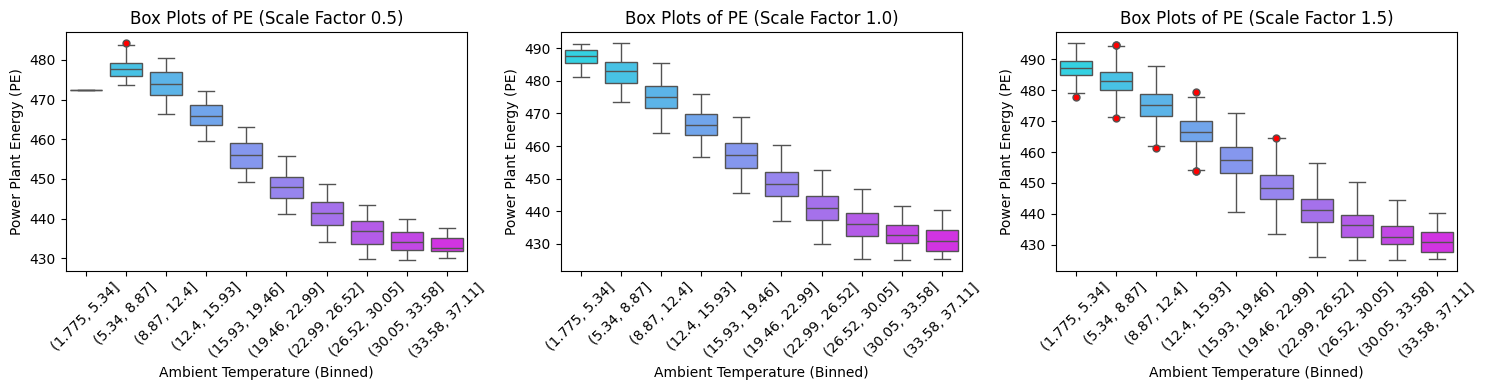

In [11]:
# Create a copy of the original df to avoid altering it
binned_df_test = df.copy()

# Feature bin creation in the new dataframe
binned_df_test['Ambient_Temperature_bin'] = pd.cut(binned_df_test['Ambient_Temperature'], bins=10)
binned_df_test['Relative_Humidity_bin'] = pd.cut(binned_df_test['Relative_Humidity'], bins=10)
binned_df_test['Atmospheric_Pressure_bin'] = pd.cut(binned_df_test['Atmospheric_Pressure'], bins=10)
binned_df_test['Vacuum_bin'] = pd.cut(binned_df_test['Vacuum'], bins=10)

# List of binned features
binned_features = [
    'Atmospheric_Pressure_bin',
    'Relative_Humidity_bin',
    'Ambient_Temperature_bin',
    'Vacuum_bin'
]

# Different scale factors to test
scale_factors = [0.5,1.0, 1.5]

# Set up subplots
plt.figure(figsize=(15, 4))
plot_number = 1

# Red outliers
flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')

for scale in scale_factors:
    # Copy the binned dataframe for outlier removal
    df_outliers_removed_test = binned_df_test.copy()
    removed_indices = []  # Set an empty list for removed_indices before adding to list

    # Apply remove_outliers() to each binned feature for the current scale factor
    for feature in binned_features:
        df_outliers_removed_test, outliers = remove_outliers(
            df_outliers_removed_test,
            feature,
            'Electrical_Power_Output',
            scale_factor=scale
)
        removed_indices.extend(outliers.tolist())
    # Plot the result for this scale factor as a subplot (1 row x 3 plots)
    plt.subplot(1, 3, plot_number)
    sns.boxplot(
        x='Ambient_Temperature_bin',
        y='Electrical_Power_Output',
        data=df_outliers_removed_test,
        palette='cool',
        hue='Ambient_Temperature_bin',
        legend=False,
        flierprops=flierprops
)
    plt.title(f'Box Plots of PE (Scale Factor {scale})')
    plt.xlabel('Ambient Temperature (Binned)')
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45, size=10)
    # Move to next subplot
    plot_number += 1

# Show all subplots
plt.tight_layout()
plt.show()

# Bin PE by all features, then remove all outliers

In [12]:
# Bin and remove outliers
# Create a copy of the original df to avoid altering it
binned_df = df.copy()

# Feature bin creation in the new dataframe
binned_df['Ambient_Temperature_bin'] = pd.cut(binned_df['Ambient_Temperature'], bins=10)
binned_df['Relative_Humidity_bin'] = pd.cut(binned_df['Relative_Humidity'], bins=10)
binned_df['Atmospheric_Pressure_bin'] = pd.cut(binned_df['Atmospheric_Pressure'], bins=10)
binned_df['Vacuum_bin'] = pd.cut(binned_df['Vacuum'], bins=10)

# List of binned features
binned_features = [
    'Atmospheric_Pressure_bin',
    'Relative_Humidity_bin',
    'Ambient_Temperature_bin',
    'Vacuum_bin'
]
df_outliers_removed = binned_df.copy() # copy binned df to remove outliers from
removed_indices = [] # Set an empty list for removed_indices before adding to list

# Apply outlier_removal() to each binned feature
for feature in binned_features:
    df_outliers_removed, outliers = remove_outliers(df_outliers_removed, feature, 'Electrical_Power_Output')
    removed_indices.extend(outliers.tolist())

# Outlier and index checks
print(f"Count of total removed binned PE outliers: {len(removed_indices)}")
remaining_indices = set(removed_indices).intersection(df_outliers_removed.index)
if remaining_indices:
    print(f"Original binned PE outliers remaining after removal: {list(remaining_indices)}")
else:
    print("No original binned PE outliers remaining.")

Count of total removed binned PE outliers: 1256
No original binned PE outliers remaining.


# Plot of removed outliers (AT vs PE)

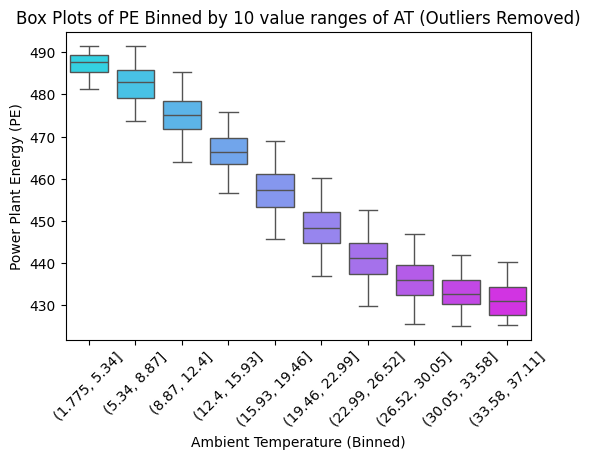

In [13]:
# Create a copy of the df_outliers_removed to avoid altering it
binned_df = df_outliers_removed.copy()
binned_df['Ambient_Temperature_bin'] = pd.cut(binned_df['Ambient_Temperature'], bins=10)

plt.figure(figsize=(6, 4))

# Plot and labels
sns.boxplot(
    x='Ambient_Temperature_bin',
    y='Electrical_Power_Output',
    data=binned_df,
    palette='cool',
    hue='Ambient_Temperature_bin',
    legend=False
)
plt.title('Box Plots of PE Binned by 10 value ranges of AT (Outliers Removed)')
plt.xlabel('Ambient Temperature (Binned)')
plt.ylabel('Power Plant Energy (PE)')
plt.xticks(rotation=45, size=10)
plt.show()

In [14]:
df_outliers_removed.describe().T

,count,mean,std,min,25%,50%,75%,max
Ambient_Temperature,8312.0,20.413526,7.207974,1.81,14.350,21.40,26.17,37.11
Vacuum,8312.0,55.425673,12.647239,25.36,42.340,57.25,67.45,80.18
Atmospheric_Pressure,8312.0,1013.344418,6.008049,992.89,1009.200,1013.08,1017.39,1033.30
Relative_Humidity,8312.0,73.314429,14.241457,25.56,63.755,74.85,84.42,100.16
Electrical_Power_Output,8312.0,452.400439,16.302910,425.11,438.730,448.79,465.78,491.54


In [15]:
# Define each dataframe's features for analysis
original_df_features = df[[
                        'Ambient_Temperature',
                        'Atmospheric_Pressure',
                        'Relative_Humidity',
                        'Vacuum'
]]

no_out_features = df_outliers_removed[[
                    'Ambient_Temperature',
                    'Atmospheric_Pressure',
                    'Relative_Humidity',
                    'Vacuum'
]]

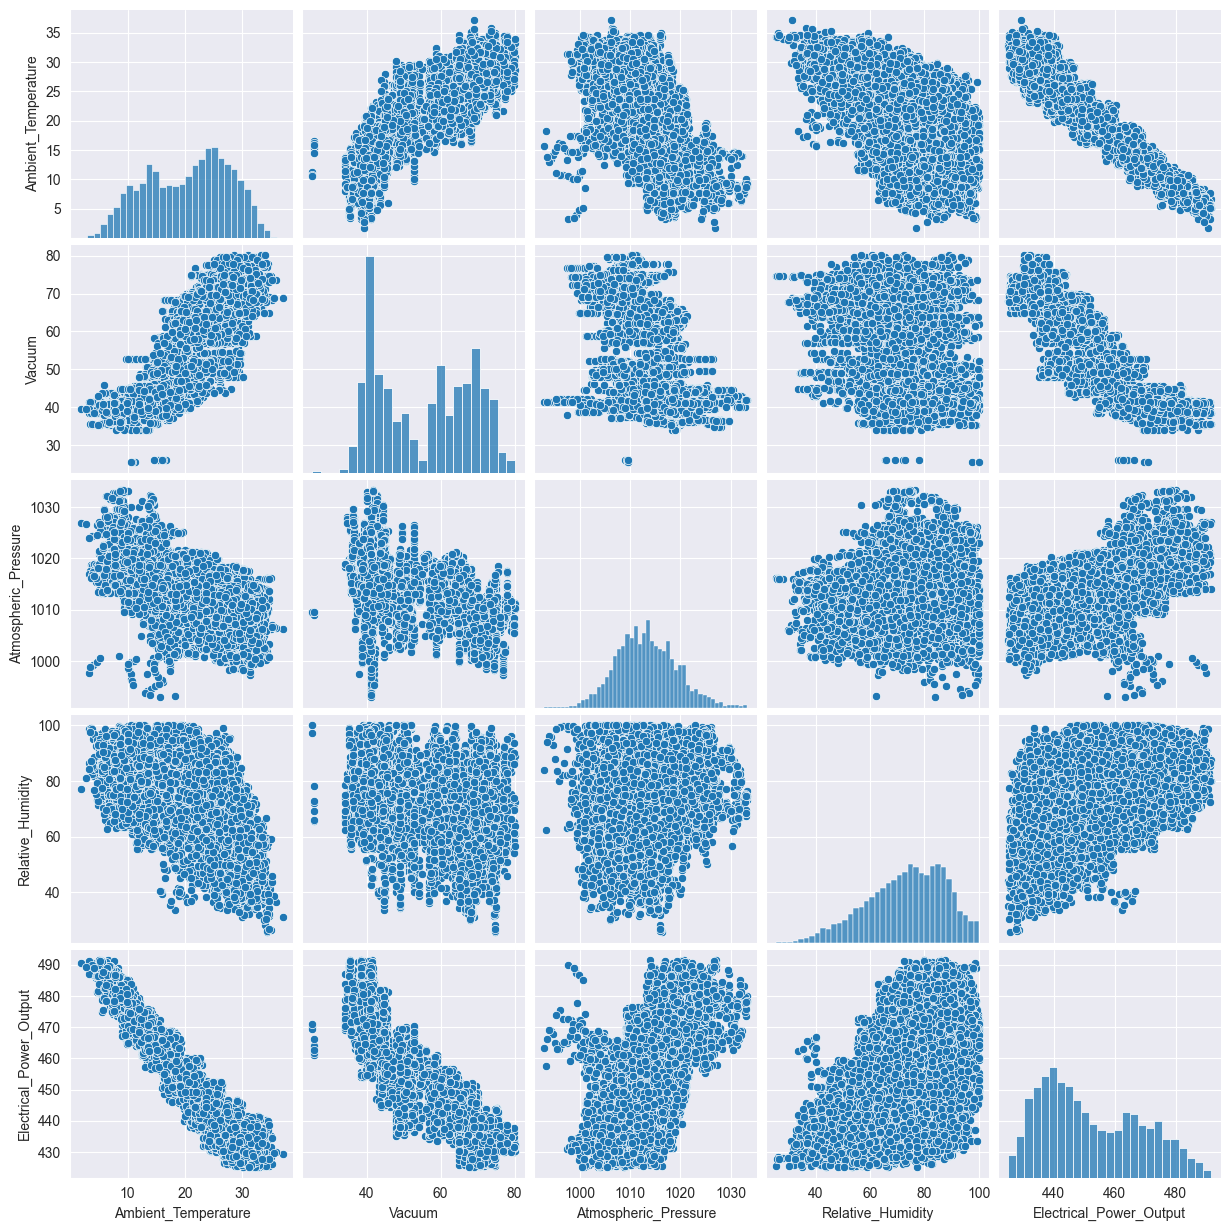

In [16]:
sns.set_style('darkgrid')
sns.pairplot(df_outliers_removed)

# Calculate VIF$(X_i)$=1 / 1- $R_i^{2}$

<Figure size 600x400 with 0 Axes>

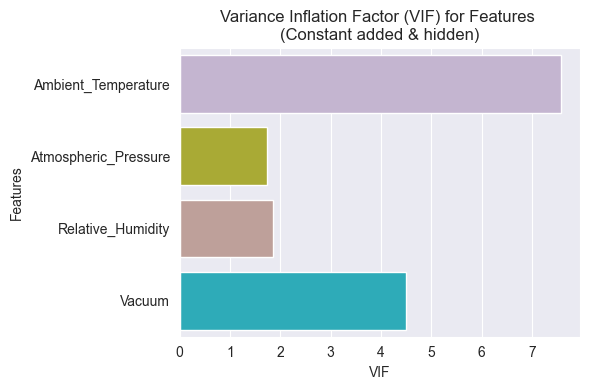

In [17]:
# Define feature variables (AP, RH, AT, V)
X = no_out_features
# Add a constant for the intercept in the linear regression
X = sm.add_constant(X)
y = df['Electrical_Power_Output']
plt.figure(figsize=(6, 4))

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out the constant from the plot
vif = vif[vif["Feature"] != "const"]

# Plot VIF values as a bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='VIF', y='Feature', data=vif,palette='tab20',hue=y,legend=False)
plt.title("Variance Inflation Factor (VIF) for Features \n(Constant added & hidden)")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Feature Correlations

<Axes: >

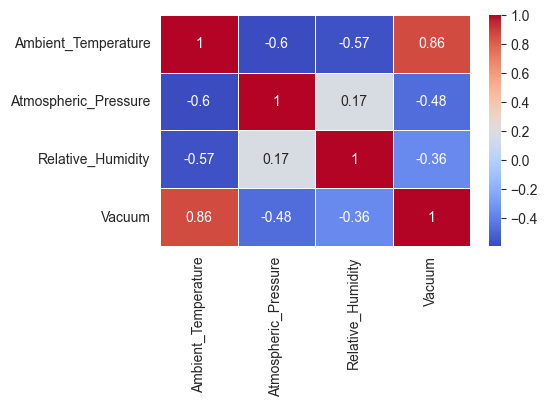

In [18]:
# Correlation between the features
plt.figure(figsize=(5, 3))
sns.heatmap(no_out_features.corr(), annot=True, cmap='coolwarm', linewidths=0.5)

# Train OLS model

In [19]:
df_outliers_removed.head()

,Ambient_Temperature,Vacuum,Atmospheric_Pressure,Relative_Humidity,Electrical_Power_Output,Ambient_Temperature_bin,Relative_Humidity_bin,Atmospheric_Pressure_bin,Vacuum_bin
1,23.64,58.49,1011.40,74.20,445.75,"(22.99, 26.52]","(70.32, 77.78]","(1009.054, 1013.095]","(53.46, 59.08]"
2,29.74,56.90,1007.15,41.91,438.76,"(26.52, 30.05]","(40.48, 47.94]","(1005.013, 1009.054]","(53.46, 59.08]"
3,19.07,49.69,1007.22,76.79,453.09,"(15.93, 19.46]","(70.32, 77.78]","(1005.013, 1009.054]","(47.84, 53.46]"
4,11.80,40.66,1017.13,97.20,464.43,"(8.87, 12.4]","(92.7, 100.16]","(1013.095, 1017.136]","(36.6, 42.22]"
5,13.97,39.16,1016.05,84.60,470.96,"(12.4, 15.93]","(77.78, 85.24]","(1013.095, 1017.136]","(36.6, 42.22]"


In [20]:
X = no_out_features
y = df_outliers_removed['Electrical_Power_Output']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                               OLS Regression Results                              
Dep. Variable:     Electrical_Power_Output   R-squared:                       0.938
Model:                                 OLS   Adj. R-squared:                  0.937
Method:                      Least Squares   F-statistic:                 3.116e+04
Date:                     Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                             19:42:28   Log-Likelihood:                -23472.
No. Observations:                     8312   AIC:                         4.695e+04
Df Residuals:                         8307   BIC:                         4.699e+04
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

# Variable Combination Check

### **Residuals should be homoscedastic (constant variance)**
 Step : check the residuals vs fitted plot. if the residuals are randomly scattered around the 0 line, the residuals are homoscedastic. if the residuals have a pattern, the residuals are heteroscedastic.

 From the plot, we can see that the residuals are randomly scattered around the 0 line, so the **residuals are homoscedastic.**


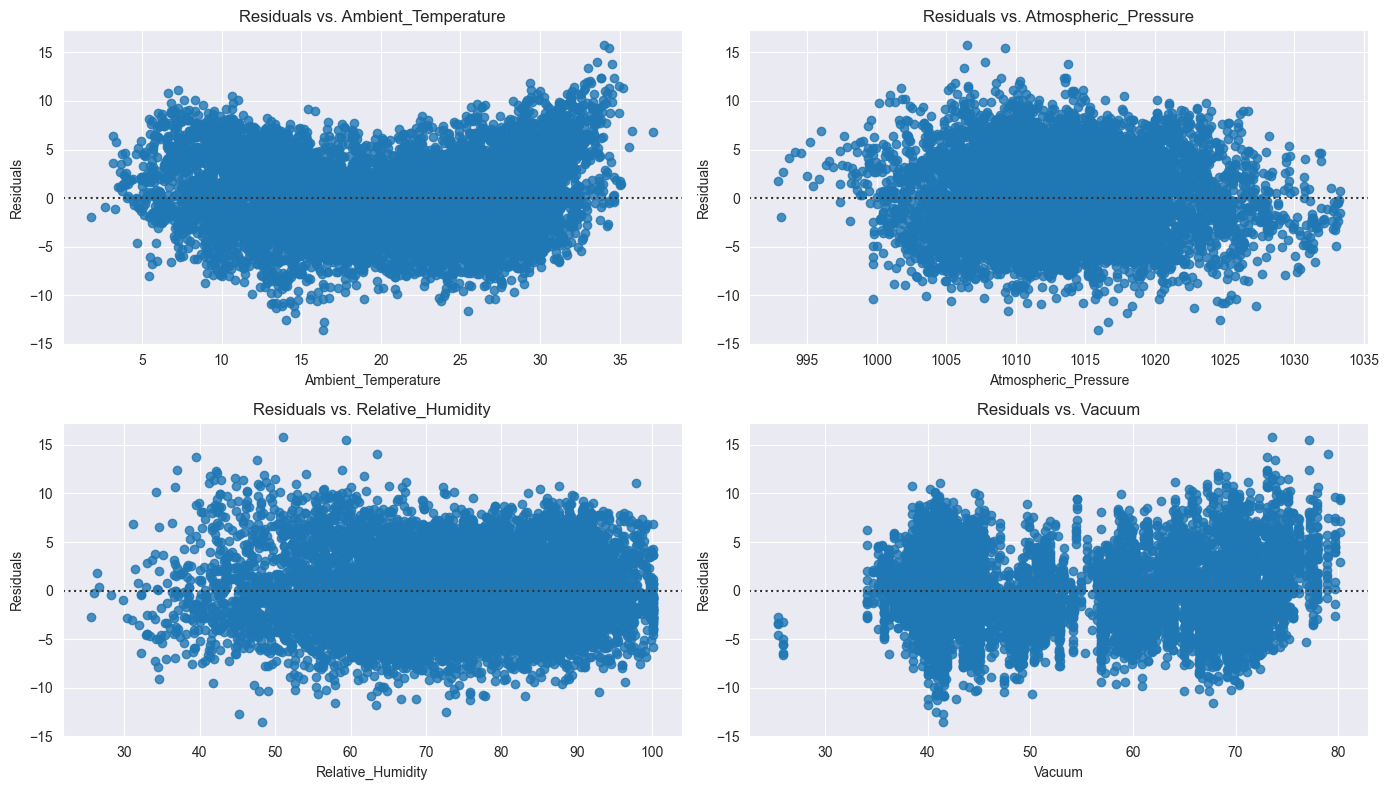

In [21]:
X = no_out_features
# Number of columns (features)
n_features = len(X.columns)

# Create subplots: number of rows and columns (adjust depending on how many plots you want per row)
n_rows = (n_features + 1) // 2  # Arrange 2 plots per row
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize based on the number of plots

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot residuals for each feature
for idx, i in enumerate(X.columns):
    sns.residplot(x=X[i], y=est2.resid, ax=axes[idx])  # Use ax parameter to plot in the correct subplot
    axes[idx].set_xlabel(i)
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'Residuals vs. {i}')

# Remove any unused subplots if the number of features is odd
if n_features % 2 != 0:
    fig.delaxes(axes[-1])  # Remove the last subplot if not needed

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

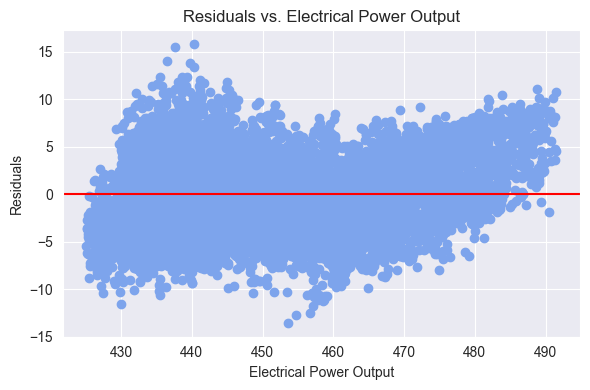

In [22]:
## Residuals vs Y
plt.figure(figsize=(6, 4))
plt.scatter(df_outliers_removed['Electrical_Power_Output'], est2.resid, color='#7da4ec')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Electrical Power Output')
plt.xlabel('Electrical Power Output')
plt.ylabel('Residuals')
plt.tight_layout()

# Check the residuals vs predictor plot
If the residuals are randomly scattered around the 0 line, the residuals are homoscedastic. if the residuals have a pattern, the residuals are heteroscedastic.
From the plot, we can see that the residuals are randomly scattered around the 0 line, so the **residuals are homoscedastic**.  So, the model satisfies the assumption of homoscedasticity.

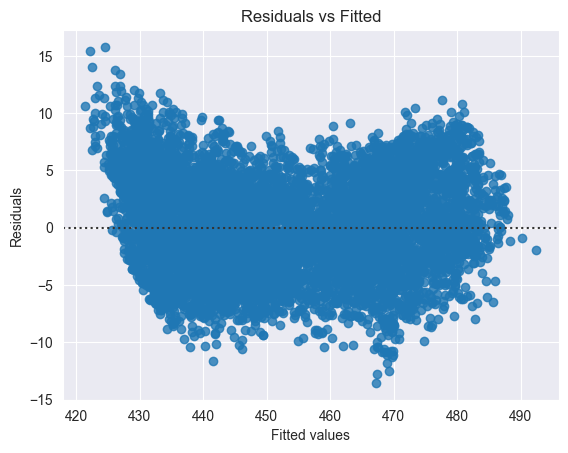

In [23]:
import seaborn as sns
sns.residplot(x=est2.fittedvalues, y=est2.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

### **Residuals should be normally distributed**

Step: Check the distribution of the residuals.
  
**From the histogram, we can see that the residuals are normally distributed.**
  


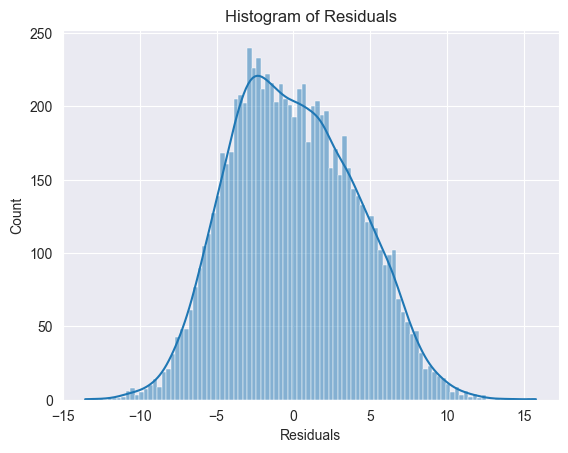

In [24]:
import seaborn as sns
sns.histplot(est2.resid, kde=True, bins=100)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

### Check the QQ plot of the residuals
**From the QQ plot, we can see that the residuals are normally distributed.** 
How to interpret the QQ plot:
- If the residuals are normally distributed, the points in the QQ plot should fall on the straight line. In the below QQ plot, we can see that the points are falling on the straight line, so the residuals are normally distributed.  

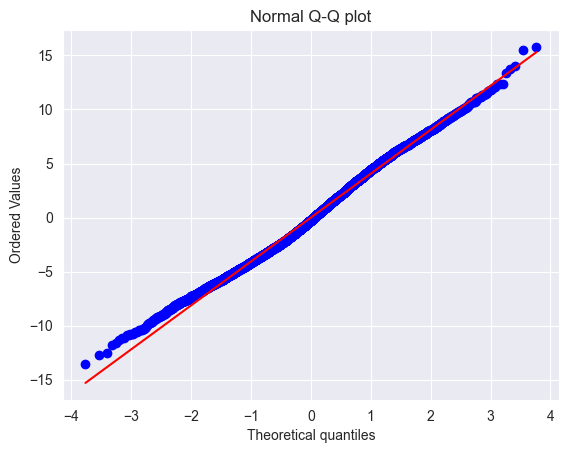

In [25]:
import scipy.stats as stats
stats.probplot(est2.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

# F-Test
#### Null Hypothesis: The model is not statistically significant
#### Alternative Hypothesis: The model is statistically significant

In [26]:
X= no_out_features
X= sm.add_constant(X)
y = df_outliers_removed['Electrical_Power_Output']

model=sm.OLS(y, X).fit()

# F test
f_test_results=model.f_test(
    'Relative_Humidity=0,'
    'Vacuum=0,'
    'Atmospheric_Pressure=0,'
    'Ambient_Temperature=0'
)
print(f_test_results)
# F test p-value
f_test_results.pvalue
# p-value is less than 0.05, so we reject the null hypothesis and conclude
# that the model is statistically significant
if f_test_results.pvalue<0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

<F test: F=31155.131866986307, p=0.0, df_denom=8.31e+03, df_num=4>
Reject the null hypothesis


# Model Comparison Class

In [27]:
####################################################################################
#
#   Base Class for the Model
#
####################################################################################
class Model:
    def __init__(
        self,
        X,y,
        test_size=0.2,
        random_state=42,
        val_size=0.25,
        model="LinearRegression"
):
        '''
        Parameters:
        X: Features
        y: Target
        test_size: Test size
        random_state: Random state
        val_size: Validation size
        model: Model to be used
        '''
        self.model_name = model
        self.models = {
            "LinearRegression": {
                "model": lambda X, y: LinearRegression(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "OLS": {
                "model":lambda X, y: sm.OLS(y, X),
                "fit": lambda X, y: self.model.fit()
            },
            "DecisionTreeRegressor": {
                "model": lambda X, y: DecisionTreeRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "RandomForestRegressor": {
                "model": lambda X, y: RandomForestRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "GradientBoostingRegressor": {
                "model": lambda X, y: GradientBoostingRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "AdaBoostRegressor": {
                "model": lambda X, y: AdaBoostRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "BaggingRegressor": {
                "model": lambda X, y: BaggingRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            },
            "SVR": {
                "model": lambda X, y: SVR(),
                "fit": lambda X, y: self.model.fit(X, y)
            }
            ,
            "MLPRegressor": {
                "model": lambda X, y: MLPRegressor(),
                "fit": lambda X, y: self.model.fit(X, y)
            }
        }
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.val_size = val_size
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X,
            self.y,
            test_size=self.test_size,
            random_state=self.random_state
)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train,
            self.y_train,
            test_size=self.val_size,
            random_state=self.random_state
)
        self.model = self.models[self.model_name]['model'](self.X_train, self.y_train)

    @staticmethod
    def get_models():
        return [
            "LinearRegression",
            "OLS",
            "DecisionTreeRegressor",
            "RandomForestRegressor",
            "GradientBoostingRegressor",
            "AdaBoostRegressor",
            "BaggingRegressor",
            "SVR",
            "MLPRegressor"
]

    def train(self):
        self.model=self.models[self.model_name]['fit'](self.X_train, self.y_train)
        return self.evaluate(self.X_train, self.y_train)

    def predict(self, X):
        return self.model.predict(X)
    
    def validate(self):
        return self.evaluate(self.X_val, self.y_val)
    
    def test(self):
        return self.evaluate(self.X_test, self.y_test)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        return np.round((mse, mae, r2), decimals=2)
    
    def summary(self):
        return self.model.summary()
    
    def plotResiduals(self, X, y):
        residuals = y - self.predict(X)
        sns.scatterplot(x=self.predict(X), y=residuals)
        plt.xlabel('Predictions')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs. Predictions')
        plt.show()

    def plot_residuals(self):
        self.plotResiduals(self.X_val, self.y_val)
    
    def plot_residuals_test(self):
        self.plotResiduals(self.X_test, self.y_test)

    def plot_residuals_val(self):
        self.plotResiduals(self.X_val, self.y_val)

# Multiple Model comparison (outliers removed)

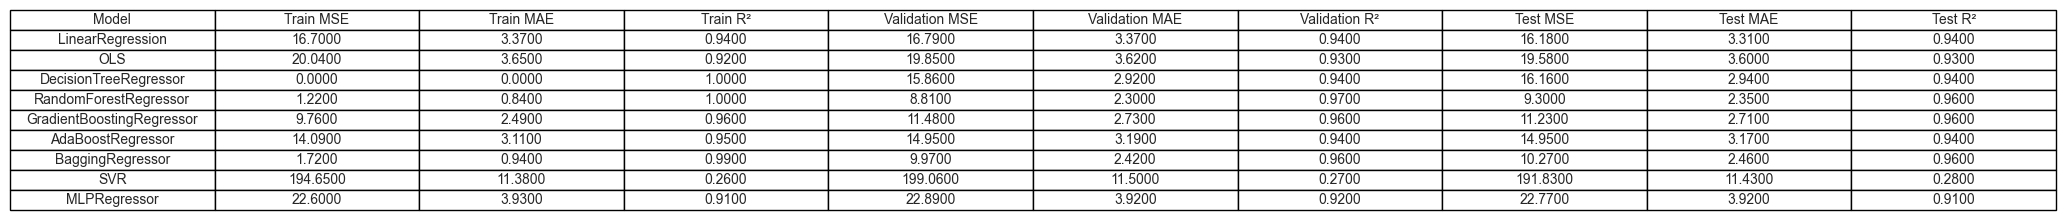

In [28]:
import matplotlib.pyplot as plt
from matplotlib.table import Table
X = no_out_features
y = df_outliers_removed['Electrical_Power_Output']
# Collect the data into a list of lists
data = [['Model',
         'Train MSE',
         'Train MAE',
         'Train R²',
         'Validation MSE',
         'Validation MAE',
         'Validation R²',
         'Test MSE',
         'Test MAE',
         'Test R²'
]]

for model_name in Model.get_models():
    model = Model(X, y, model=model_name)
    train_results = model.train()
    validation_results = model.validate()
    test_results = model.test()
    
    # Append each row of model results to the data list
    data.append([model_name,
                 f'{train_results[0]:.4f}', f'{train_results[1]:.4f}', f'{train_results[2]:.4f}',
                 f'{validation_results[0]:.4f}', f'{validation_results[1]:.4f}', f'{validation_results[2]:.4f}',
                 f'{test_results[0]:.4f}', f'{test_results[1]:.4f}', f'{test_results[2]:.4f}'])

# Plotting the table
fig, ax = plt.subplots(figsize=(22, 2.5))  # Create a figure and a set of subplots
ax.axis('tight')
ax.axis('off')

# Create a table plot
table = ax.table(cellText=data, colLabels=None, cellLoc='center', loc='center')

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column width for better readability
table.scale(1.2, 1.2)

# Display the table plot
plt.show()

# Best feature combinations

In [29]:
# for all combinations of columns
from itertools import combinations
X = no_out_features
y = df_outliers_removed['Electrical_Power_Output']
cols = X.columns
# Store the results in  matrix
best_combinations=[]
for trial in range(100):
    results = {}
    for i in range(2, len(cols)+1):
        for comb in combinations(cols, i):
            X = df_outliers_removed[list(comb)]
            model = Model(X, y,random_state=np.random.randint(0,100))
            model.train()
            mse, mae, r2=model.validate()
            results[comb] = (mse, mae, r2)
    # Find the best combination
    best_comb = min(results, key=results.get)
    best_combinations.append(best_comb)

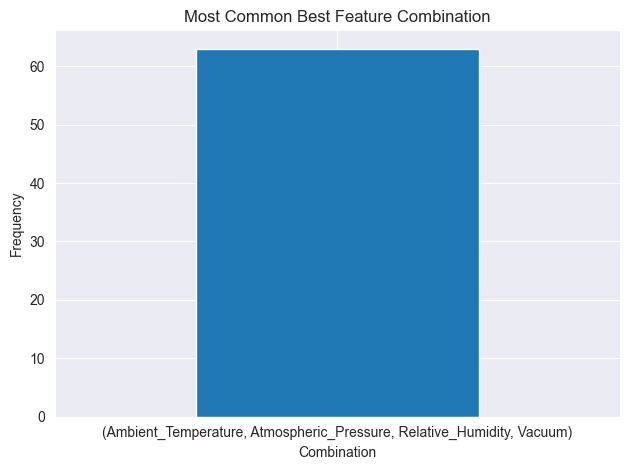

In [30]:
# Plot best variable combination
pd.DataFrame(best_combinations).value_counts().plot(kind='bar')

# Set labels and title
plt.xlabel('Combination')
plt.ylabel('Frequency')
plt.title('Most Common Best Feature Combination')

# Rotate x-axis labels to horizontal format
plt.xticks(rotation=0, ha='center', wrap=True)  # Rotate labels horizontally and center align them

# Show the plot
plt.tight_layout()
plt.show()

# Prediction plots (Linear Regression)

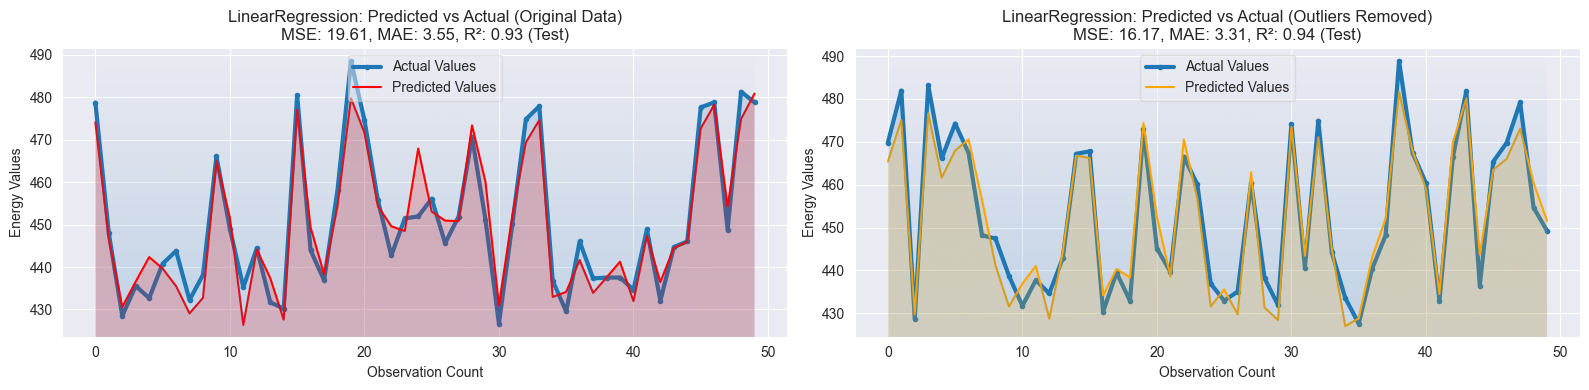

In [31]:
# Limit observations to plot (test set for plot)
start_obs = 150
end_obs = 200

# Set random seed for reproducibility
np.random.seed(42)
# Features (X) and target (y) - Original df
X = original_df_features
y = df['Electrical_Power_Output']

# First split: training + test sets (original df)
# Test size: 20%, training size: 80%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: training into training + validation sets (original df)
# split 80% training into 64% training and 16% validation.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42
)
# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set (original df)
y_test_predictions = model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_predictions)
mae_test = mean_absolute_error(y_test, y_test_predictions)
r2_test = r2_score(y_test, y_test_predictions)

# Now for the outliers removed DataFrame (df_outliers_removed)
# Features (X) and target (y) - Outliers removed
X_outliers = no_out_features
y_outliers = df_outliers_removed['Electrical_Power_Output']

# Train-test split for outliers removed
X_train_full_outliers, X_test_outliers, y_train_full_outliers, y_test_outliers = train_test_split(
    X_outliers,
    y_outliers,
    test_size=0.2,
    random_state=42
)
X_train_outliers, X_val_outliers, y_train_outliers, y_val_outliers = train_test_split(
    X_train_full_outliers,
    y_train_full_outliers,
    test_size=0.2,
    random_state=42
)
# Initialize and fit the Linear Regression model on outliers removed
model_outliers = LinearRegression()
model_outliers.fit(X_train_outliers, y_train_outliers)

# Make predictions on the test set (outliers removed)
y_test_predictions_outliers = model_outliers.predict(X_test_outliers)

# Calculate performance metrics on the test set for outliers removed
mse_test_outliers = mean_squared_error(y_test_outliers, y_test_predictions_outliers)
mae_test_outliers = mean_absolute_error(y_test_outliers, y_test_predictions_outliers)
r2_test_outliers = r2_score(y_test_outliers, y_test_predictions_outliers)

# Plot size
plt.figure(figsize=(16, 4))

# Selecting part of the data for plotting (original df)
predictions_num = y_test_predictions[start_obs:end_obs]
y_test_num = y_test.iloc[start_obs:end_obs]
x_values_num = np.arange(len(predictions_num))

# Selecting part of the data for plotting (outliers removed)
predictions_num_outliers = y_test_predictions_outliers[start_obs:end_obs]
y_test_num_outliers = y_test_outliers.iloc[start_obs:end_obs]

# Plot for original df
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(x_values_num, y_test_num, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num, linewidth=1.5, label='Predicted Values', color='red')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'LinearRegression: Predicted vs Actual (Original Data)\n'
          f'MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.2f} (Test)')
plt.xlabel('Observation Count')
plt.ylabel('Energy Values')
plt.legend(loc='upper center', framealpha=0.5)
plt.tight_layout()

# Plot for df_outliers_removed
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(x_values_num, y_test_num_outliers, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num_outliers, linewidth=1.5, label='Predicted Values', color='orange')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'LinearRegression: Predicted vs Actual (Outliers Removed)\n'
          f'MSE: {mse_test_outliers:.2f}, MAE: {mae_test_outliers:.2f}, R²: {r2_test_outliers:.2f} (Test)')
plt.xlabel('Observation Count')
plt.ylabel('Energy Values')
plt.legend(loc='upper center', framealpha=0.5)
plt.tight_layout()

# Show the plots
plt.show()

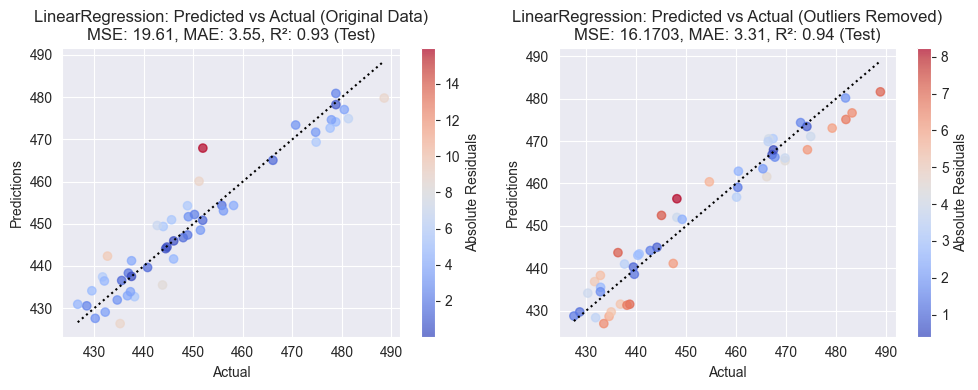

In [32]:
# Model used
model = LinearRegression()
model.fit(X_train, y_train)

# Train-test split sizes
test_size_original = X_test.shape[0]
test_size_outliers_removed = X_test_outliers.shape[0]

# Calculate residuals
residuals = predictions_num - y_test_num

# Calculate residuals
residuals_outliers = predictions_num_outliers - y_test_num_outliers

# Plot size
plt.figure(figsize=(10, 4))

# Plot for original data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.scatter(y_test_num, predictions_num, c=np.abs(residuals), cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Absolute Residuals')
plt.title(f'LinearRegression: Predicted vs Actual (Original Data)\n'
          f'MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.2f} (Test)')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], color='black', linestyle=':')

# Plot for outliers removed
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.scatter(y_test_num_outliers, predictions_num_outliers, c=np.abs(residuals_outliers), cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Absolute Residuals')
plt.title(f'LinearRegression: Predicted vs Actual (Outliers Removed)\n'
          f'MSE: {mse_test_outliers:.4f}, MAE: {mae_test_outliers:.2f}, R²: {r2_test_outliers:.2f} (Test)')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.plot(
    [min(y_test_num_outliers),
     max(y_test_num_outliers)],
    [min(y_test_num_outliers),
     max(y_test_num_outliers)],
    color='black',
    linestyle=':'
)
# Show the side-by-side plots
plt.tight_layout()
plt.show()

# Prediction plots (RandomForestRegressor)

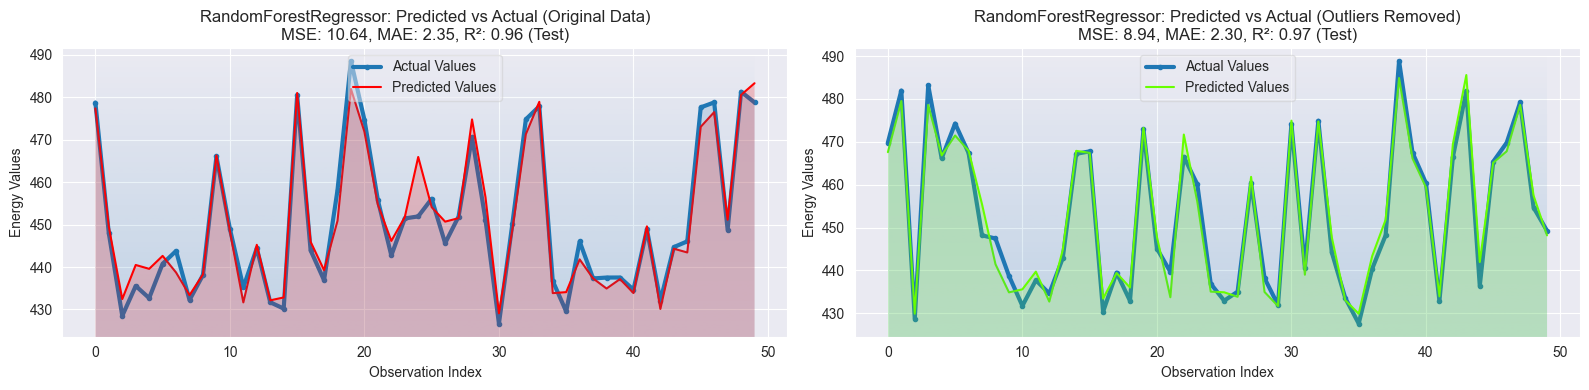

In [33]:
# Limit observations to plot (test set for plot)
start_obs = 150
end_obs = 200

# Set random seed for reproducibility
np.random.seed(42)

# Features (X) and target (y) - Original df
X = original_df_features
y = df['Electrical_Power_Output']
# First split: training + test sets (original df)
# Test size: 20%, training size: 80%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: training into training + validation sets (original df)
# split 80% training into 64% training and 16% validation.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42
)
# Initialize and fit the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set (original df)
y_test_predictions = model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_test_predictions)
mae_test = mean_absolute_error(y_test, y_test_predictions)
r2_test = r2_score(y_test, y_test_predictions)

# Now for the outliers removed DataFrame (df_outliers_removed)
# Features (X) and target (y) - Outliers removed
X_outliers = no_out_features
y_outliers = df_outliers_removed['Electrical_Power_Output']

# Train-test split for outliers removed
X_train_full_outliers, X_test_outliers, y_train_full_outliers, y_test_outliers = train_test_split(
    X_outliers,
    y_outliers,
    test_size=0.2,
    random_state=42
)
X_train_outliers, X_val_outliers, y_train_outliers, y_val_outliers = train_test_split(
    X_train_full_outliers,
    y_train_full_outliers,
    test_size=0.2,
    random_state=42
)
# Initialize and fit the Random Forest model on outliers removed
model_outliers = RandomForestRegressor(random_state=42)
model_outliers.fit(X_train_outliers, y_train_outliers)

# Make predictions on the test set (outliers removed)
y_test_predictions_outliers = model_outliers.predict(X_test_outliers)

# Calculate performance metrics on the test set for outliers removed
mse_test_outliers = mean_squared_error(y_test_outliers, y_test_predictions_outliers)
mae_test_outliers = mean_absolute_error(y_test_outliers, y_test_predictions_outliers)
r2_test_outliers = r2_score(y_test_outliers, y_test_predictions_outliers)

# Plot size
plt.figure(figsize=(16, 4))

# Selecting part of the data for plotting (original df)
predictions_num = y_test_predictions[start_obs:end_obs]
y_test_num = y_test.iloc[start_obs:end_obs]
x_values_num = np.arange(len(predictions_num))

# Selecting part of the data for plotting (outliers removed)
predictions_num_outliers = y_test_predictions_outliers[start_obs:end_obs]
y_test_num_outliers = y_test_outliers.iloc[start_obs:end_obs]

# Plot for original df
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(x_values_num, y_test_num, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num, linewidth=1.5, label='Predicted Values', color='red')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'RandomForestRegressor: Predicted vs Actual (Original Data)\n'
          f'MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.2f} (Test)')
plt.xlabel('Observation Index')
plt.ylabel('Energy Values')
plt.legend(loc='upper center', framealpha=0.5)
plt.tight_layout()

# Plot for df_outliers_removed
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(x_values_num, y_test_num_outliers, linewidth=3, marker='.', label='Actual Values')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='top')  # underglow specs
plt.plot(x_values_num, predictions_num_outliers, linewidth=1.5, label='Predicted Values', color='#68ff00')
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')  # underglow specs
plt.title(f'RandomForestRegressor: Predicted vs Actual (Outliers Removed)\n'
          f'MSE: {mse_test_outliers:.2f}, MAE: {mae_test_outliers:.2f}, R²: {r2_test_outliers:.2f} (Test)')
plt.xlabel('Observation Index')
plt.ylabel('Energy Values')
plt.legend(loc='upper center', framealpha=0.5)
plt.tight_layout()

# Show the plots
plt.show()

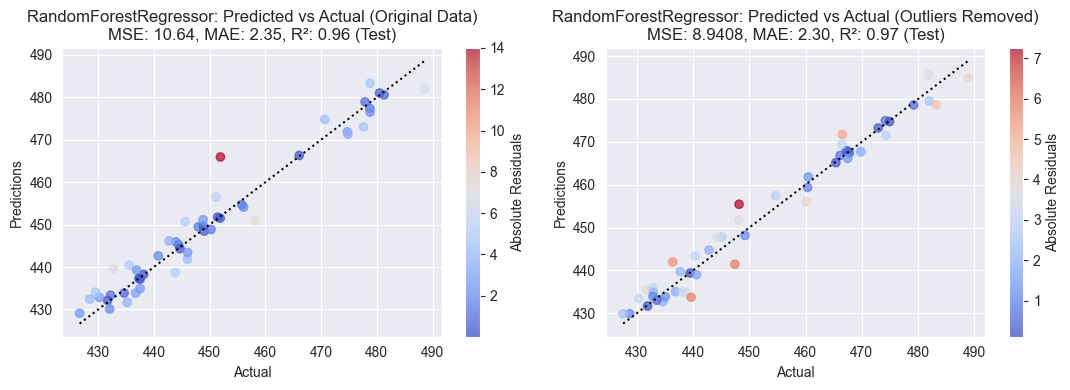

In [34]:
# Model used
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Train-test split sizes
test_size_original = X_test.shape[0]
test_size_outliers_removed = X_test_outliers.shape[0]

# Calculate residuals
residuals = predictions_num - y_test_num

# Calculate residuals
residuals_outliers = predictions_num_outliers - y_test_num_outliers

# Plot size
plt.figure(figsize=(11, 4))

# Plot for original data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.scatter(y_test_num, predictions_num, c=np.abs(residuals), cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Absolute Residuals')
plt.title(f'RandomForestRegressor: Predicted vs Actual (Original Data)\n'
          f'MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.2f} (Test)')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], color='black', linestyle=':')

# Plot for outliers removed
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.scatter(y_test_num_outliers, predictions_num_outliers, c=np.abs(residuals_outliers), cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Absolute Residuals')
plt.title(f'RandomForestRegressor: Predicted vs Actual (Outliers Removed)\n'
          f'MSE: {mse_test_outliers:.4f}, MAE: {mae_test_outliers:.2f}, R²: {r2_test_outliers:.2f} (Test)')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.plot(
    [min(y_test_num_outliers),
     max(y_test_num_outliers)],
    [min(y_test_num_outliers),
     max(y_test_num_outliers)],
    color='black',
    linestyle=':'
)
# Show the side-by-side plots
plt.tight_layout()
plt.show()